In [2]:
# Cell 1 - setup
!pip install -q tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
print("TF", tf.__version__)

TF 2.19.0


In [3]:
# Cell 2 - load
csv_path = "energy_data3_ori.csv"
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print(df.columns.tolist())
# Use Voltage, Current, Power
data = df[['Voltage','Current','Power']].astype(float).reset_index(drop=True)
display(data.head())

Shape: (367, 4)
['Timestamp', 'Voltage', 'Current', 'Power']


,Voltage,Current,Power
0,2.4232,0.0061,0.0148
1,2.4208,0.0061,0.0148
2,2.4240,0.0059,0.0143
3,2.4184,0.0061,0.0148
4,2.4168,0.0060,0.0145


In [4]:
# Cell 3 - scaling + sequences (flatten)
scaler = MinMaxScaler((0,1))
scaled = scaler.fit_transform(data)   # shape (N, 3)

look_back = 30   # you can reduce to 10 if memory tight
X_list, y_list = [], []
for i in range(len(scaled) - look_back):
    window = scaled[i:i+look_back]          # shape (look_back, 3)
    X_list.append(window.flatten())         # shape (look_back*3,)
    y_list.append(scaled[i+look_back, 2])   # next step power (scaled)

X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (337, 90) y shape: (337,)


In [5]:
# Cell 4 - split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (269, 90) Test: (68, 90)


In [6]:
# Cell 5 - model
tf.keras.backend.clear_session()
input_dim = X_train.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),
    Dense(32, activation='relu'),   # tiny: 32 units
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cell 6 - training
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
chk = ModelCheckpoint("best_mlp.h5", save_best_only=True, monitor='val_loss')
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200, batch_size=16,
                    callbacks=[es, chk], verbose=2)

Epoch 1/200


17/17 - 3s - 158ms/step - loss: 0.1191 - mae: 0.2609 - val_loss: 0.0826 - val_mae: 0.2090
Epoch 2/200


17/17 - 0s - 9ms/step - loss: 0.0810 - mae: 0.1967 - val_loss: 0.0777 - val_mae: 0.1838
Epoch 3/200


17/17 - 0s - 9ms/step - loss: 0.0623 - mae: 0.1579 - val_loss: 0.0612 - val_mae: 0.1889
Epoch 4/200


17/17 - 0s - 9ms/step - loss: 0.0589 - mae: 0.1656 - val_loss: 0.0489 - val_mae: 0.1351
Epoch 5/200


17/17 - 0s - 9ms/step - loss: 0.0515 - mae: 0.1518 - val_loss: 0.0442 - val_mae: 0.1267
Epoch 6/200


17/17 - 0s - 9ms/step - loss: 0.0483 - mae: 0.1412 - val_loss: 0.0355 - val_mae: 0.1206
Epoch 7/200


17/17 - 0s - 8ms/step - loss: 0.0455 - mae: 0.1354 - val_loss: 0.0334 - val_mae: 0.1200
Epoch 8/200


17/17 - 0s - 8ms/step - loss: 0.0456 - mae: 0.1388 - val_loss: 0.0328 - val_mae: 0.1214
Epoch 9/200
17/17 - 0s - 7ms/step - loss: 0.0458 - mae: 0.1363 - val_loss: 0.0400 - val_mae: 0.1224
Epoch 10/200


17/17 - 0s - 9ms/step - loss: 0.0434 - mae: 0.1336 - val_loss: 0.0296 - val_mae: 0.0979
Epoch 11/200
17/17 - 0s - 7ms/step - loss: 0.0384 - mae: 0.1247 - val_loss: 0.0324 - val_mae: 0.1016
Epoch 12/200
17/17 - 0s - 7ms/step - loss: 0.0419 - mae: 0.1349 - val_loss: 0.0373 - val_mae: 0.1172
Epoch 13/200


17/17 - 0s - 10ms/step - loss: 0.0372 - mae: 0.1249 - val_loss: 0.0291 - val_mae: 0.0945
Epoch 14/200


17/17 - 0s - 8ms/step - loss: 0.0358 - mae: 0.1133 - val_loss: 0.0270 - val_mae: 0.1108
Epoch 15/200


17/17 - 0s - 9ms/step - loss: 0.0354 - mae: 0.1238 - val_loss: 0.0250 - val_mae: 0.0855
Epoch 16/200
17/17 - 0s - 7ms/step - loss: 0.0353 - mae: 0.1161 - val_loss: 0.0259 - val_mae: 0.0906
Epoch 17/200
17/17 - 0s - 7ms/step - loss: 0.0332 - mae: 0.1130 - val_loss: 0.0263 - val_mae: 0.0865
Epoch 18/200
17/17 - 0s - 7ms/step - loss: 0.0338 - mae: 0.1125 - val_loss: 0.0287 - val_mae: 0.0943
Epoch 19/200
17/17 - 0s - 7ms/step - loss: 0.0322 - mae: 0.1124 - val_loss: 0.0260 - val_mae: 0.0840
Epoch 20/200


17/17 - 0s - 9ms/step - loss: 0.0326 - mae: 0.1105 - val_loss: 0.0245 - val_mae: 0.0936
Epoch 21/200
17/17 - 0s - 8ms/step - loss: 0.0314 - mae: 0.1062 - val_loss: 0.0254 - val_mae: 0.1046
Epoch 22/200
17/17 - 0s - 7ms/step - loss: 0.0300 - mae: 0.1057 - val_loss: 0.0252 - val_mae: 0.0834
Epoch 23/200


17/17 - 0s - 9ms/step - loss: 0.0291 - mae: 0.0990 - val_loss: 0.0232 - val_mae: 0.0798
Epoch 24/200
17/17 - 0s - 7ms/step - loss: 0.0288 - mae: 0.1018 - val_loss: 0.0238 - val_mae: 0.0894
Epoch 25/200
17/17 - 0s - 7ms/step - loss: 0.0288 - mae: 0.0985 - val_loss: 0.0244 - val_mae: 0.0985
Epoch 26/200


17/17 - 0s - 8ms/step - loss: 0.0285 - mae: 0.1033 - val_loss: 0.0229 - val_mae: 0.0816
Epoch 27/200
17/17 - 0s - 7ms/step - loss: 0.0279 - mae: 0.1001 - val_loss: 0.0252 - val_mae: 0.1004
Epoch 28/200
17/17 - 0s - 7ms/step - loss: 0.0284 - mae: 0.0986 - val_loss: 0.0239 - val_mae: 0.0824
Epoch 29/200
17/17 - 0s - 9ms/step - loss: 0.0268 - mae: 0.0952 - val_loss: 0.0240 - val_mae: 0.0798
Epoch 30/200
17/17 - 0s - 7ms/step - loss: 0.0253 - mae: 0.0904 - val_loss: 0.0232 - val_mae: 0.0894
Epoch 31/200
17/17 - 0s - 7ms/step - loss: 0.0259 - mae: 0.0952 - val_loss: 0.0259 - val_mae: 0.0881
Epoch 32/200
17/17 - 0s - 7ms/step - loss: 0.0263 - mae: 0.0950 - val_loss: 0.0233 - val_mae: 0.0902
Epoch 33/200
17/17 - 0s - 7ms/step - loss: 0.0284 - mae: 0.1067 - val_loss: 0.0233 - val_mae: 0.0891
Epoch 34/200
17/17 - 0s - 8ms/step - loss: 0.0259 - mae: 0.0997 - val_loss: 0.0293 - val_mae: 0.1034
Epoch 35/200
17/17 - 0s - 8ms/step - loss: 0.0250 - mae: 0.0998 - val_loss: 0.0253 - val_mae: 0.0928
Epo

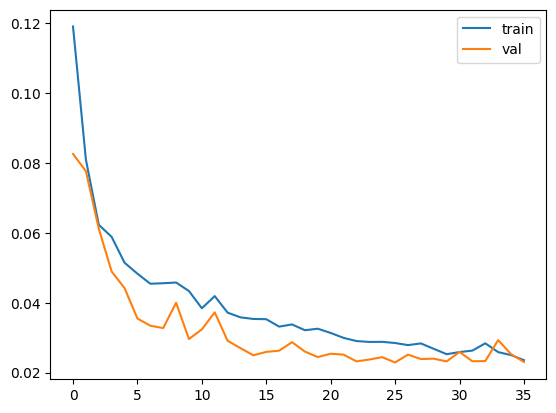

Test MSE: 0.02291768044233322 MAE(scaled): 0.0815611258149147
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


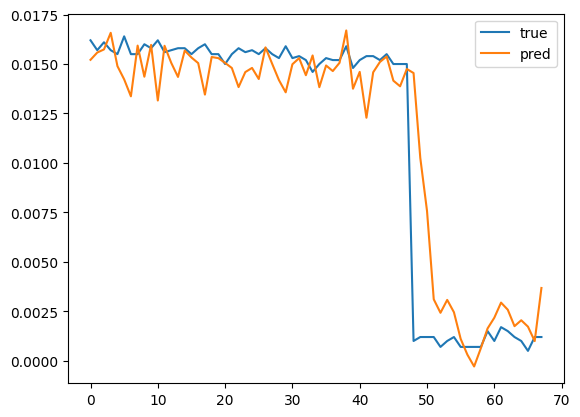

In [8]:
# Cell 7 - eval & plot
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.show()
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE:", loss, "MAE(scaled):", mae)
# Quick inversion to real Power for last samples
preds = model.predict(X_test).flatten()
dummy = np.zeros((len(preds), 3)); dummy[:,2] = preds
inv_preds = scaler.inverse_transform(dummy)[:,2]
dummy2 = np.zeros((len(y_test),3)); dummy2[:,2] = y_test
inv_y = scaler.inverse_transform(dummy2)[:,2]
plt.plot(inv_y[-200:], label='true'); plt.plot(inv_preds[-200:], label='pred'); plt.legend(); plt.show()

In [9]:
# Cell 8 - save and quantize
model.save("tiny_mlp.h5")

def rep_gen():
    # yield (1, input_dim) float32 samples
    for i in range(0, min(1000, X_train.shape[0]), 5):
        yield [np.expand_dims(X_train[i].astype(np.float32), axis=0)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant = converter.convert()
open("tiny_mlp_int8.tflite","wb").write(tflite_quant)
print("Wrote tiny_mlp_int8.tflite (bytes):", len(tflite_quant))

Saved artifact at '/tmp/tmp_k6xfgui'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 90), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132480983374672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132480991024656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132480983373712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132480983372560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132480983376208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132480983375632: TensorSpec(shape=(), dtype=tf.resource, name=None)
Wrote tiny_mlp_int8.tflite (bytes): 6968


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [10]:
# Cell 9 - test interpreter
interpreter = tf.lite.Interpreter(model_path="tiny_mlp_int8.tflite")
interpreter.allocate_tensors()
inh = interpreter.get_input_details()[0]
outh = interpreter.get_output_details()[0]
print("Input:", inh)
print("Output:", outh)

# Test with first test sample
sample = X_test[0:1].astype(np.float32)
if inh['dtype'] == np.int8:
    scale, zp = inh['quantization']
    sample_q = (sample / scale + zp).astype(np.int8)
    interpreter.set_tensor(inh['index'], sample_q)
else:
    interpreter.set_tensor(inh['index'], sample)
interpreter.invoke()
out = interpreter.get_tensor(outh['index'])
if outh['dtype'] == np.int8:
    o_scale, o_zp = outh['quantization']
    out_deq = (out.astype(np.float32) - o_zp) * o_scale
else:
    out_deq = out
print("Model output (dequantized, scaled):", out_deq)
# Convert to real units
dummy_out = np.zeros((1,3)); dummy_out[0,2] = out_deq
print("Predicted Power (real units):", scaler.inverse_transform(dummy_out)[0,2])

Input: {'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 90], dtype=int32), 'shape_signature': array([-1, 90], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Output: {'name': 'StatefulPartitionedCall_1:0', 'index': 9, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0042086755856871605, -128), 'quantization_parameters': {'scales': array([0.00420868], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Model output (dequantized, scaled): [[0.91749126]]
Predicted Power (real units): 0.015179860115051269


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/tmp/ipython-input-2905068230.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy_out = np.zeros((1,3)); dummy_out[0,2] = out_deq


In [11]:
# Cell 10 - export header
with open("tiny_mlp_int8.tflite","rb") as f:
    b = f.read()
name = "tiny_mlp_int8"
with open(f"{name}.h","w") as fh:
    fh.write("#ifndef MODEL_DATA_H\n#define MODEL_DATA_H\n\n")
    fh.write(f"const unsigned char {name}[] = {{\n")
    for i,byte in enumerate(b):
        fh.write(str(byte))
        if i != len(b)-1: fh.write(",")
        if (i+1)%20==0: fh.write("\n")
    fh.write("\n};\n")
    fh.write(f"const unsigned int {name}_len = {len(b)};\n\n#endif\n")
print("Wrote", f"{name}.h")

Wrote tiny_mlp_int8.h
